In [1]:
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from dataclasses import dataclass

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from econml.dml import CausalForestDML

import rustrees.tree as rt
from rustrees.rustrees import DecisionTree, RandomForest

# Plot settings
plt.style.use('seaborn')
sns.set_theme(style="ticks")

/home/glazari/tests/rust-trees/.env/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/glazari/tests/rust-trees/.env/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

In [2]:
@dataclass
class DGP:
    n: int = 100
    p: int = 0.5

    def __post_init__(self):
        self.df = self.generate_potential_outcomes()
    
    def generate_baseline(self, seed: int = 0) -> pd.DataFrame:
        """Generates a dataframes with the baseline outcome."""
        return pd.DataFrame()
    
    def add_treatment_effect(self, df : pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Add the treatment effect to the baseline outcome."""
        return pd.DataFrame

    def generate_potential_outcomes(self, seed: int = 0) -> pd.DataFrame:
        """Generates a dataframes with treatment and control potential outcomes."""
        df = self.generate_baseline(seed)
        df = self.add_treatment_effect(df, seed)
        for y in self.Y:
            df[y + '_t'] = df[y + '_c'] + df['effect_on_' + y]
            del df['effect_on_' + y]
        return df.round(2)

    def add_assignment(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Adds the treatment assignment variable."""
        np.random.seed(seed)
        df[self.D] = np.random.binomial(1, self.p, self.n)
        return df

    def generate_data(self, seed_data: int = 0, seed_assignment: int = 1, **kwargs) -> pd.DataFrame:
        """Generate potential outcomes, add assignment and select realized outcomes."""
        df = self.generate_potential_outcomes(seed_data, **kwargs)
        df = self.add_assignment(df, seed_assignment)
        d = df[self.D].values
        for y in self.Y:
            df[y] = df[y + '_c'].values * (1-d) + df[y + '_t'].values * d
            del df[y + '_c']
            del df[y + '_t']
        return df

    def evaluate_f_redrawing_data(self, f, K):
        """Evaluates the function f on K draws of the data (both potential outcomes and treatment assignment)."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_data=i, seed_assignment=K-i)) for i in range(K))
        return results

    def evaluate_f_redrawing_outcomes(self, f, K):
        """Evaluates the function f on K draws of the treatment assignment. Potential outcomes are fixed."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_assignment=i)) for i in range(K))
        return results
    
    def evaluate_f_redrawing_potentialoutcomes(self, f, K):
        """Evaluates the function f on K draws of the potential outcomes."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_potential_outcomes(seed_data=i)) for i in range(K))
        return results


In [3]:
class dgp_online_discounts(DGP):
    """DGP: online discounts"""
    devices = ['desktop', 'mobile']
    browsers = ['chrome', 'safari', 'firefox', 'explorer', 'edge', 'brave', 'other']
    regions = [str(x) for x in range(10)]
    X: list[str] = ['time', 'device', 'browser', 'region']
    D: str = 'discount'
    Y: list[str] = ['spend']

    def generate_baseline(self, seed:int = 0):
        np.random.seed(seed)
        time = np.random.beta(1, 1, size=self.n) * 24
        device = np.random.choice(self.devices, size=self.n)
        browser = np.random.choice(self.browsers, size=self.n)
        region = np.random.choice(self.regions, size=self.n)
        spend_c = np.random.exponential(10, self.n) - 5
        df = pd.DataFrame({'spend_c': spend_c, 'time': time, 'device': device, 'browser': browser, 'region': region})
        return df
    
    def add_treatment_effect(self, df, seed:int = 0):
        np.random.seed(seed)
        effect = 7*np.exp(-(df.time-18)**2/100) + 3*(df.browser=='safari') - 2*(df.device=='desktop') + (df.region=='3')
        df['effect_on_spend'] = np.maximum(0, effect)
        return df

In [4]:
dgp = dgp_online_discounts(n=100_000)
df = dgp.generate_data()
df.head()

,time,device,browser,region,discount,spend
0,10.78,mobile,edge,9,0,0.46
1,0.57,desktop,firefox,9,1,11.04
2,3.74,mobile,safari,7,0,1.81
3,13.37,desktop,other,5,0,31.90
4,0.71,mobile,explorer,2,0,15.42


In [5]:
smf.ols('spend ~ discount', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.0306,0.046,109.949,0.000,4.941,5.120
discount,3.8568,0.065,59.597,0.000,3.730,3.984


In [6]:
df_dummies = pd.get_dummies(df[dgp.X[1:]], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)
X = ['time'] + list(df_dummies.columns)

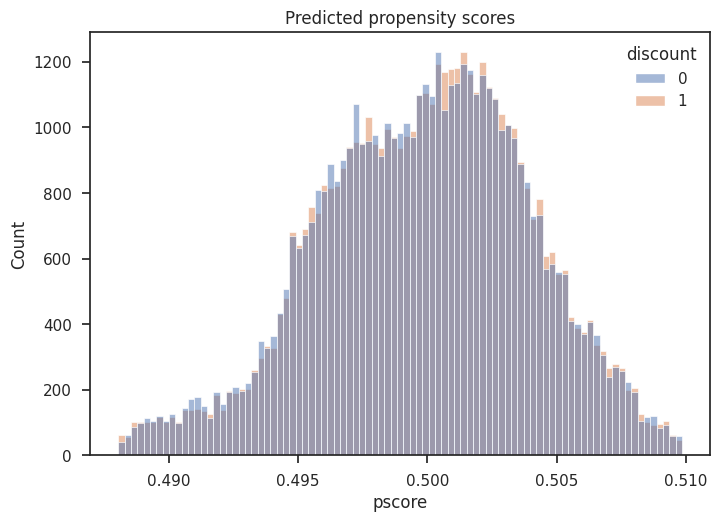

In [7]:
from sklearn.linear_model import LogisticRegression

df['pscore'] = LogisticRegression().fit(df[X], df[dgp.D]).predict_proba(df[X])[:,1]
sns.histplot(data=df, x='pscore', hue='discount').set(title='Predicted propensity scores');

In [8]:
df['y_star'] = df[dgp.Y[0]] / (df[dgp.D] * df['pscore'] - (1-df[dgp.D]) * (1-df['pscore']))

In [9]:
df['y_star'].mean()

3.8512943695973028

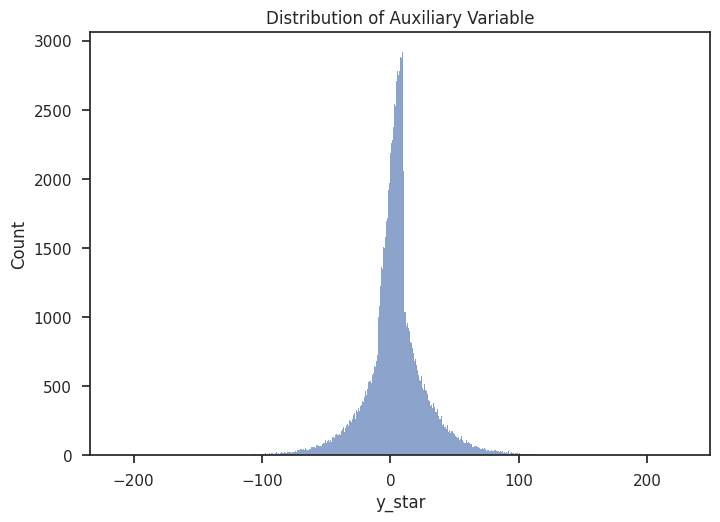

In [10]:
sns.histplot(df['y_star']).set(title='Distribution of Auxiliary Variable');

In [11]:
%%time
tree = DecisionTreeRegressor(max_depth=2).fit(df[X], df['y_star'])
# df['y_hat'] = tree.predict(df[X])
# df['y_hat'].mean()

CPU times: user 32.5 ms, sys: 1.01 ms, total: 33.5 ms
Wall time: 32.6 ms


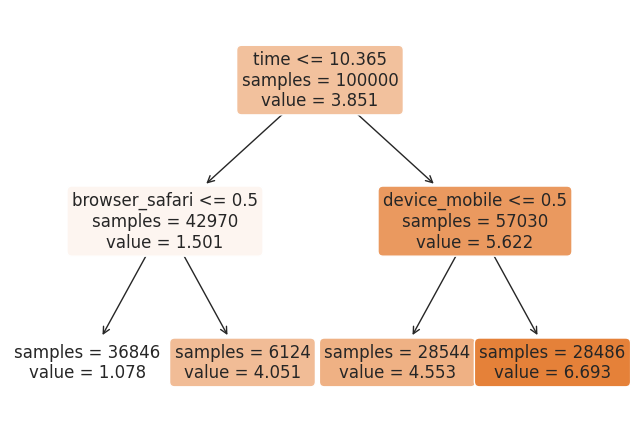

In [12]:
from sklearn.tree import plot_tree

plot_tree(tree, filled=True, fontsize=12, feature_names=X, impurity=False, rounded=True);

In [13]:
%%time
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=2)
tree_model = tree_model.fit(Y=df[dgp.Y], X=df[X], T=df[dgp.D])

CPU times: user 5.83 s, sys: 14.4 s, total: 20.3 s
Wall time: 1.49 s


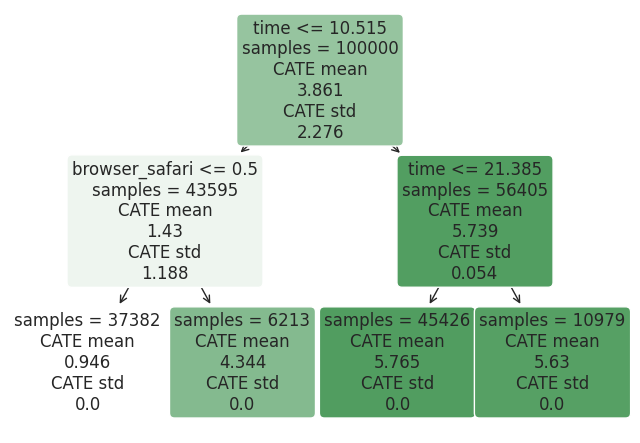

In [14]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, df[X])
intrp.plot(feature_names=X, fontsize=12)

In [15]:
def compute_discrete_effects(df, hte_model):
    temp_df = df.copy()
    temp_df.time = 0
    temp_df = dgp.add_treatment_effect(temp_df)
    temp_df = temp_df.rename(columns={'effect_on_spend': 'True'})
    temp_df['Predicted'] = hte_model.effect(temp_df[X])
    df_effects = pd.DataFrame()
    for var in X[1:]:
        for effect in ['True', 'Predicted']:
            v = temp_df[effect][temp_df[var]==1].mean() - temp_df[effect][temp_df[var]==0].mean()
            effect_var = {'Variable': [var], 'Effect': [effect], 'Value': [v]}
            df_effects = pd.concat([df_effects, pd.DataFrame(effect_var)]).reset_index(drop=True)
    return df_effects, temp_df['Predicted'].mean()

In [16]:
df_effects_tree, avg_effect_notime_tree = compute_discrete_effects(df, tree_model)

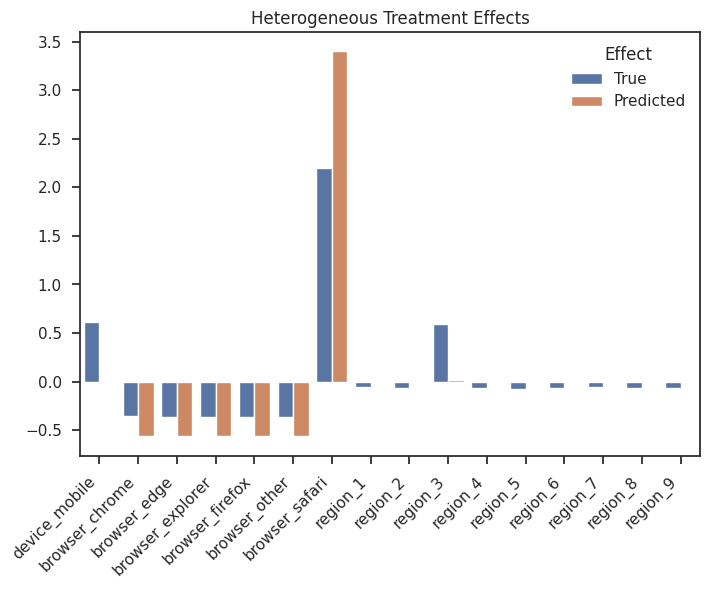

In [17]:
fig, ax = plt.subplots()
sns.barplot(data=df_effects_tree, x="Variable", y="Value", hue="Effect", ax=ax).set(
    xlabel='', ylabel='', title='Heterogeneous Treatment Effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


In [18]:
def compute_time_effect(df, hte_model, avg_effect_notime):
    df_time = df.copy()
    df_time[[X[1:]] + ['device', 'browser', 'region']] = 0
    df_time = dgp.add_treatment_effect(df_time)
    df_time['predicted'] = hte_model.effect(df_time[X]) + avg_effect_notime
    return df_time

In [19]:
df_time_tree = compute_time_effect(df, tree_model, avg_effect_notime_tree)

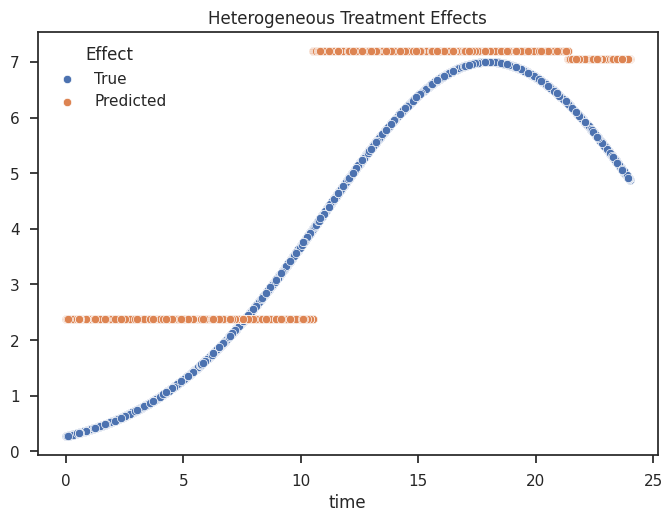

In [20]:
sns.scatterplot(x='time', y='effect_on_spend', data=df_time_tree, label='True')
sns.scatterplot(x='time', y='predicted', data=df_time_tree, label='Predicted').set(
    ylabel='', title='Heterogeneous Treatment Effects')
plt.legend(title='Effect');

In [21]:
df_rt = rt.from_pandas(df[X+["y_star"]])

In [22]:
%%time
tree = DecisionTree.train_reg(df_rt, max_depth=2)
# df['y_hat'] = tree.predict(df_rt)
# df['y_hat'].mean()

CPU times: user 113 ms, sys: 2.34 ms, total: 115 ms
Wall time: 114 ms


In [23]:
%%time
tree = RandomForest.train_reg(df_rt, max_depth=2, n_estimators=100)
# df['y_hat'] = tree.predict(df_rt)
# df['y_hat'].mean()

CPU times: user 21.9 s, sys: 292 ms, total: 22.1 s
Wall time: 1.61 s
